<a href="https://colab.research.google.com/github/andremartins7/IntComp/blob/main/Competi%C3%A7%C3%A3o_1_Andre_Joao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Predição de Cobertura de um Plano de Saúde**
##Competição 1: Classificação de requisições para cobertura do Plano de Saúde.

1a Competição da disciplina de Inteligência Computacional 2022/2

# **1. Análise exploratória dos dados**
A EDA é usada principalmente para identificar o que os dados podem revelar além da tarefa formal de modelagem ou teste de hipótese e proporciona uma melhor compreensão das variáveis do conjunto de dados e as relações entre eles.

Foi utilizada a visualização univariada de cada campo no conjunto de dados bruto, com estatísticas resumidas.

# **2. Pré-processamentos realizados**
Para tratar as features de data utilizamos a função para converter datas de / para JD e MJD. [link](https://github.com/meshula/exifotio/blob/master/jdutil.py)

Trabalhamos com os valores nulos de diferentes formas, tanto para o dataset de treino como para o de teste.
Para os valores faltantes para a feature DT_NASCIMENTO por exemplo, nos datasets de treino e teste foram preenchidos utilizando a mediana.

As colunas que estavam em timestamp foram convertidas para datetime. Foi utilizado o encoding cyclical para criar as features relacionadas ao mês, dia da semana e dia do mês a partir da data de requisição. Com isso, foi criado uma feature de idade através da diferença entre a data da requisição e a data de nascimento. [Link](https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/)

# **3. Configuração experimental**
Validação cruzada foi utilizada pois caso sejam usadas as features de sequência, pode ocorrer data leakage na validação cruzada, pois um mesmo valor da coluna "NR_SEQ_REQUISICAO" pode estar presente em diferentes folds.

# **4. Algoritmos utilizados**

Random Forest é um algoritmo de aprendizado supervisionado. Tem duas variações – uma é usada para problemas de classificação e outra é usada para problemas de regressão. É um dos algoritmos mais flexíveis e fáceis de usar. Ele cria árvores de decisão nas amostras de dados fornecidas, obtém previsões de cada árvore e seleciona a melhor solução por meio de votação. Também é um bom indicador da importância do recurso.

O algoritmo Random Forest combina várias árvores de decisão, resultando em uma floresta de árvores, daí o nome Random Forest. No classificador de floresta aleatória, quanto maior o número de árvores na floresta, maior a precisão.

# **5. A declaração do problema**

O dataset é composto por dados preenchidos por um colaborador da prestadora (hospital, clínica, laboratório ou consultório) requisitando cobertura das despesas de produtos e serviços prestados ao cliente (beneficiário do plano), os aqui disponibilizados foram anonimizados e fornecidos por uma operadora de plano de saúde (dados reais).

# Importação das bibliotecas

In [ ]:
# Instalando a biblioteca para encode
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 766 kB/s 


In [ ]:
# Importanto as bibliotecas a serem utilizadas
import math
import numpy as np
import pandas as pd
import datetime as dt
import lightgbm as lgb
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# Carregar Dataset

In [ ]:
df_train = pd.read_csv('train.csv', delimiter=',')
df_test = pd.read_csv('test.csv', delimiter=',')

# Alterando os valores da coluna alvo para 0 e 1
df_train['DS_STATUS_ITEM'] = df_train['DS_STATUS_ITEM'].replace({'Negado':1, 'Autorizado':0})

In [ ]:
# Visualizando as cinco primeiras linhas do Dataset
df_train.head(5)

,Unnamed: 0,NR_SEQ_REQUISICAO,NR_SEQ_ITEM,DT_REQUISICAO,DS_TIPO_GUIA,DT_NASCIMENTO,NR_PRODUTO,DS_TIPO_PREST_SOLICITANTE,DS_CBO,DS_TIPO_CONSULTA,...,CD_CID,DS_INDICACAO_CLINICA,DS_TIPO_ITEM,CD_ITEM,DS_ITEM,DS_CLASSE,DS_SUBGRUPO,DS_GRUPO,QT_SOLICITADA,DS_STATUS_ITEM
0,1,1120527,2905946,2459367,Guia de solicitac?o SP/SADT,2439348.0,1,PRESTADOR DE SERVICOS,Medico dermatologista,NaN,...,NaN,INDICACAO CLINICA EM ANEXO.,Procedimentos,30101298,ELETROCOAGULAC?O DE LES?ES DE PELE E MUCOSAS -...,PROCEDIMENTOS,PELE E TECIDO CELULAR SUBCUTANEO/ANEXOS,PROCED. CIRURGICOS E INVASIVOS,1.0,0
1,2,615210,1333736,2459091,Guia de solicitac?o internac?o,2443536.0,1,HOSPITAL,Medico clinico,NaN,...,B342,Paciente positivo para COVID 19 ha 10 dias com...,Procedimentos,10102019,VISITA HOSPITALAR A PACIENTE INTERNADO,VISITAS,CONSULTAS,PROCED. GERAIS,1.0,0
2,4,1135757,897098,2459375,Guia de solicitac?o SP/SADT,2439815.0,1,CLINICA,Medico ortopedista e traumatologista,NaN,...,M16,DOR CRONICA NO QUADRIL E COLUNA LOMBAR,MAT/MED,37765,NAUSEDRON 2 MG/ML SOL INJ CX 50 AMP VD INC X 2...,ANTIEMETICOS E ANTINAUSEANTES,"SISTEMA DIGESTIVO, METABOLISMO E NUTRICAO+SIST...",Brasindice,1.0,0
3,6,1088493,2800174,2459352,Guia de solicitac?o SP/SADT,2439139.0,1,CLINICA DE IMAGEM,Medico oncologista clinico,NaN,...,NaN,PANCREATITE DE REPETIC?O,Procedimentos,41101170,"RM - ABDOME SUPERIOR (FIGADO, PANCREAS, BACO, ...",RESSONANCIA MAGNETICA DIAGNOSTICA,RESSONANCIA MAGNETICA,PROCED. DIAGNOSTICOS E TERAPEUTICOS,1.0,0
4,7,936746,2311078,2459268,Guia de solicitac?o SP/SADT,2435595.0,1,CLINICA,Medico oftalmologista,NaN,...,NaN,NaN,Procedimentos,41301269,MICROSCOPIA ESPECULAR DE CORNEA - MONOCULAR,PROCEDIMENTOS,EXAMES ESPECIFICOS,PROCED. DIAGNOSTICOS E TERAPEUTICOS,2.0,1


# Análise exploratória dos dados

In [ ]:
# Função para analisar o dataset
def load_info(data):
  print('\nA forma do conjunto de dados é:', data.shape)
  print('\nThe headof the dataset is:\n', data.head(5))
  print('\nO cabeçalho do conjunto de dados é:\n', data.dtypes)  
  print('\nA descrição do conjunto de dados é:\n',data.describe())
  print('\nExistem valores nulos?\n', data.isnull().sum())

In [ ]:
# análise de df_train
load_info(df_train)


A forma do conjunto de dados é: (227122, 32)

The headof the dataset is:
    Unnamed: 0  NR_SEQ_REQUISICAO  NR_SEQ_ITEM  DT_REQUISICAO  \
0           1            1120527      2905946        2459367   
1           2             615210      1333736        2459091   
2           4            1135757       897098        2459375   
3           6            1088493      2800174        2459352   
4           7             936746      2311078        2459268   

                     DS_TIPO_GUIA  DT_NASCIMENTO  NR_PRODUTO  \
0     Guia de solicitac?o SP/SADT      2439348.0           1   
1  Guia de solicitac?o internac?o      2443536.0           1   
2     Guia de solicitac?o SP/SADT      2439815.0           1   
3     Guia de solicitac?o SP/SADT      2439139.0           1   
4     Guia de solicitac?o SP/SADT      2435595.0           1   

  DS_TIPO_PREST_SOLICITANTE                                 DS_CBO  \
0     PRESTADOR DE SERVICOS                 Medico dermatologista    
1              

# Tratando os valores nulos

Para os valores faltantes na coluna DT_NASCIMENTO nos datasets de treino e teste foram preenchidos utilizando a mediana.

In [ ]:
df_train['DT_NASCIMENTO'] = df_train['DT_NASCIMENTO'].fillna(df_train['DT_NASCIMENTO'].median())
df_test['DT_NASCIMENTO'] = df_test['DT_NASCIMENTO'].fillna(df_test['DT_NASCIMENTO'].median())

Para a coluna DS_TIPO_ACOMODACAO, foi assumido que as requisições com valores faltantes podem ser tratadas como casos onde nenhuma categoria disponível se aplica.

In [ ]:
df_train['DS_TIPO_ACOMODACAO'] = df_train['DS_TIPO_ACOMODACAO'].fillna('NAO SE APLICA')
df_test['DS_TIPO_ACOMODACAO'] = df_test['DS_TIPO_ACOMODACAO'].fillna('NAO SE APLICA')

Para as colunas DS_INDICACAO_ACIDENTE e DS_TIPO_ATENDIMENTO, os valores faltantes foram preenchidos com uma categoria constante "DESCONHECIDO"

In [ ]:
df_train['DS_INDICACAO_ACIDENTE'] = df_train['DS_INDICACAO_ACIDENTE'].fillna('DESCONHECIDO')
df_train['DS_TIPO_ATENDIMENTO'] = df_train['DS_TIPO_ATENDIMENTO'].fillna('DESCONHECIDO')

df_test['DS_INDICACAO_ACIDENTE'] = df_test['DS_INDICACAO_ACIDENTE'].fillna('DESCONHECIDO')
df_test['DS_TIPO_ATENDIMENTO'] = df_test['DS_TIPO_ATENDIMENTO'].fillna('DESCONHECIDO')

In [ ]:
df_test

,Unnamed: 0,NR_SEQ_REQUISICAO,NR_SEQ_ITEM,DT_REQUISICAO,DS_TIPO_GUIA,DT_NASCIMENTO,NR_PRODUTO,DS_TIPO_PREST_SOLICITANTE,DS_CBO,DS_TIPO_CONSULTA,...,DS_TIPO_ATENDIMENTO,CD_CID,DS_INDICACAO_CLINICA,DS_TIPO_ITEM,CD_ITEM,DS_ITEM,DS_CLASSE,DS_SUBGRUPO,DS_GRUPO,QT_SOLICITADA
0,0,1560479,4348670,2459598,Guia de solicitac?o SP/SADT,2440511.0,1,HOSPITAL,Medico ortopedista e traumatologista,NaN,...,Pronto socorro,NaN,NaN,Procedimentos,60023104,PORTE 1 (CIRURGIA PEQUENA),EM CENTRO CIRURGICO,TAXA DE SALA,TAXAS,1.0
1,5,1351610,937069,2459487,Guia de solicitac?o SP/SADT,2441089.0,1,HOSPITAL,Medico clinico,NaN,...,Quimioterapia,C50,C50,MAT/MED,73512,ZEDORA 440 MG PO LIOF SOL INJ IV CT FA VD TRAN...,ANTINEOPLASICOS,AGENTES ANTINEOPLASICOS,Brasindice,880.0
2,8,1559916,4347132,2459598,Guia de solicitac?o SP/SADT,2439094.0,1,CLINICA DE IMAGEM,Medico clinico,NaN,...,Exames,NaN,NaN,Procedimentos,41001079,TC - TOMOGRAFIA COMPUTADORIZADA -TORAX,TOMOGRAFIA COMPUTADORIZADA DIAGNOSTICA,TOMOGRAFIA COMPUTADORIZADA,PROCED. DIAGNOSTICOS E TERAPEUTICOS,1.0
3,13,1516924,960836,2459571,Guia de solicitac?o SP/SADT,2442178.0,1,CLINICA,Medico ortopedista e traumatologista,NaN,...,Pequenos atendimentos,NaN,NaN,MAT/MED,162121,ATADURA GESSADA CYSNE 10CMX3MT - CM,Material de consumo,Material Hospitalar,Simpro,600.0
4,18,1484086,4111308,2459555,Guia de solicitac?o SP/SADT,2436205.0,1,CLINICA DE IMAGEM,Medico endocrinologista e metabologista,NaN,...,Exames,NaN,EM ANEXO,Procedimentos,40901203,USG - ULTRASSONOGRAFIA - ORG?OS SUPERFICIAIS (...,ULTRA-SONOGRAFIA DIAGNOSTICA,ULTRA-SONOGRAFIA,PROCED. DIAGNOSTICOS E TERAPEUTICOS,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186139,413210,1308999,3543118,2459467,Guia de solicitac?o SP/SADT,2434126.0,1,MEDICO,Medico oftalmologista,Primeira consulta,...,Exames,H40,EM ANEXO,Procedimentos,41401301,TESTE PROVOCATIVO PARA GLAUCOMA - BINOCULAR,PROCEDIMENTOS,TESTES PARA DIAGNOSTICO,PROCED. DIAGNOSTICOS E TERAPEUTICOS,1.0
186140,413218,1309100,928486,2459467,Guia de solicitac?o internac?o,2436152.0,1,HOSPITAL,Medico urologista,NaN,...,DESCONHECIDO,NaN,Paciente com calculo ureteral proximal a esque...,MAT/MED,276659,"FIO GUIA 0,014""X300CM HIDROFILICO STD J/CP STI...",Protese,Material Hospitalar,Simpro,2.0
186141,413221,1318518,3574140,2459472,Guia de solicitac?o SP/SADT,2451525.0,1,CLINICA,Medico ortopedista e traumatologista,NaN,...,Pronto socorro,NaN,PCT VITIMA DE QUEDA DE MOTO COM ESCORIAC?ES+ F...,Procedimentos,30711010,IMOBILIZAC?ES N?O-GESSADAS (QUALQUER SEGMENTO),IMOBILIZAC?ES PROVISORIAS - TALAS GESSADAS,SISTEMA MUSCULO-ESQUELETICO E ARTICULAC?ES,PROCED. CIRURGICOS E INVASIVOS,1.0
186142,413248,1300775,3515098,2459460,Guia de solicitac?o internac?o,2434417.0,1,HOSPITAL,Medico ortopedista e traumatologista,NaN,...,DESCONHECIDO,NaN,SINDROME DO TUNEL DO CARPO BILATERAL,Procedimentos,60000783,ENFERMARIA,DIARIAS,DIARIAS,DIARIAS,1.0


# Feature engineering

## Colunas de data

Função para converter datas de / para JD e MJD. Assume que as datas são históricas
datas, incluindo a transição do calendário juliano para o gregoriano
calendário em 1582. Nenhum suporte para calendários prolépticos gregorianos / julianos.

:Autor: Matt Davis
:Site: http://github.com/jiffyclub

In [ ]:
def jd_to_date(jd):
  
    jd = jd + 0.5
    
    F, I = math.modf(jd)
    I = int(I)
    
    A = math.trunc((I - 1867216.25)/36524.25)
    
    if I > 2299160:
        B = I + 1 + A - math.trunc(A / 4.)
    else:
        B = I
        
    C = B + 1524
    
    D = math.trunc((C - 122.1) / 365.25)
    
    E = math.trunc(365.25 * D)
    
    G = math.trunc((C - E) / 30.6001)
    
    day = C - E + F - math.trunc(30.6001 * G)
    
    if G < 13.5:
        month = G - 1
    else:
        month = G - 13
        
    if month > 2.5:
        year = D - 4716
    else:
        year = D - 4715
        
    return year, month, math.trunc(day)


DT_REQUISICAO e DT_NASCIMENTO em timestamp foi convertido para datetime. Foi utilizado o *encoding cyclical* para criar as features relacionadas ao mês, dia da semana e dia do mês a partir da data de requisição. Com isso, foi criado uma feature de idade através da diferença entre a data da requisição e a data de nascimento.

A objetivo é evitar usar o LabelEnconder, pois, se mapearmos cada dia da semana para um número de 1 a 7 (Domingo = 1, Segunda = 2, ..., Sábado = 7) é possível que o modelo calcule que quantidade de dias entre sábado e domingo é 6 e não 1 dia apenas. Assim, usando trigonometria para fazer o mapeamento, amenizamos o problema, pois essas funções também são cíclicas. (Referência no [link](https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/))



In [ ]:
df_train['DT_REQUISICAO'] = pd.to_datetime(df_train['DT_REQUISICAO'].map(jd_to_date).map(lambda t: '-'.join([str(k) for k in t])), format='%Y-%m-%d')
df_train['DT_NASCIMENTO'] = pd.to_datetime(df_train['DT_NASCIMENTO'].map(jd_to_date).map(lambda t: '-'.join([str(k) for k in t])), format='%Y-%m-%d')

df_train['Idade'] = pd.DatetimeIndex(df_train['DT_REQUISICAO']).year - pd.DatetimeIndex(df_train['DT_NASCIMENTO']).year

df_train['dia_x'] = np.cos(2*np.pi*pd.DatetimeIndex(df_train['DT_REQUISICAO']).weekday/7)
df_train['dia_y'] = np.sin(2*np.pi*pd.DatetimeIndex(df_train['DT_REQUISICAO']).weekday/7)

df_train['mes_dia_x'] = np.cos(2*np.pi*pd.DatetimeIndex(df_train['DT_REQUISICAO']).day/31)
df_train['mes_dia_y'] = np.sin(2*np.pi*pd.DatetimeIndex(df_train['DT_REQUISICAO']).day/31)

df_train['mes_x'] = np.cos(2*np.pi*pd.DatetimeIndex(df_train['DT_REQUISICAO']).month/12)
df_train['mes_y'] = np.sin(2*np.pi*pd.DatetimeIndex(df_train['DT_REQUISICAO']).month/12)

## Colunas de texto

As colunas DS_ITEM, DS_CLASSE e DS_INDICACAO_CLINICA parecem ter o campo de preenchimento livre, sem restrições. Na tentativa de extrair algum tipo de informação delas foram construídas três novas features contendo a quantidade de caracteres utilizadas. A intuito disso é analisar se o tamanho do texto contido nessas features tem impacto na pontuação do modelo. 

Uma quarta coluna foi criada para verificar se a presença da palavra anexo apareceu no texto DS_INDICACAO_CLINICA, para analisar se o desempenho do modelo é alterado.

In [ ]:
df_train['TAMANHO_DS_ITEM'] = df_train['DS_ITEM'].map(lambda s: len(str(s)))
df_train['TAMANHO_DS_CLASSE'] = df_train['DS_CLASSE'].map(lambda s: len(str(s)))
df_train['TAMANHO_DS_INDICACAO_CLINICA'] = df_train['DS_INDICACAO_CLINICA'].fillna('').map(lambda s: len(str(s)))

df_train['ANEXO_DS_INDICACAO_CLINICA'] = df_train['DS_INDICACAO_CLINICA'].fillna('').map(lambda s: 1 if 'anexo' in str(s).lower() else 0)

## Excluíndo colunas

In [ ]:
# Colunas que serão excluídas
features_notepad = ['DS_INDICACAO_CLINICA', 'DS_ITEM', 'DS_CLASSE'] # colunas de texto
features_useless = ['NR_PRODUTO', 'DS_TIPO_SAIDA', 'CD_ITEM'] # features que foram descosideradas
features_most_values_null = ['QT_TEMPO_DOENCA', 'DS_UNIDADE_TEMPO_DOENCA', 'DS_TIPO_CONSULTA', 'DS_TIPO_DOENCA', 'CD_GUIA_REFERENCIA'] # colunas com muitos valores nulos
features_date = ['DT_NASCIMENTO', 'DT_REQUISICAO'] # features de data

#Colunas de sequência
features_seq = ['NR_SEQ_ITEM', 'NR_SEQ_REQUISICAO']

#Essas features foram retiradas por terem o permutation importance baixo.
features_test = ['DS_TIPO_INTERNACAO', 'DS_TIPO_GUIA', 'DS_GRUPO', 'DS_REGIME_INTERNACAO', 'QT_DIA_SOLICITADO', 'QT_SOLICITADA']

features_excluidas = features_notepad + features_useless + features_most_values_null + features_date + features_test + features_seq
df_train = df_train.drop(features_excluidas, axis=1)

# Validação cruzada

Caso sejam usadas as features de sequência, pode ocorrer data leakage na validação cruzada, pois um mesmo valor da coluna "NR_SEQ_REQUISICAO" pode estar presente em diferentes folds.

In [ ]:
X = df_train.drop('DS_STATUS_ITEM', axis=1)
y = df_train['DS_STATUS_ITEM']

In [ ]:
%%time
cat_feat = df_train.select_dtypes('object')
pipe = Pipeline([
        ('encoder', ce.BinaryEncoder(cols=cat_feat, return_df=True)), 
        ('model', RandomForestClassifier(class_weight = "balanced", n_estimators=150, max_depth=30, min_samples_split=4))
])

cv_results = cross_validate(pipe, X, y, cv=10, scoring='f1', return_train_score=True, verbose=10)

print(f"{'treino':=^60}")
print(cv_results['train_score'].mean())
print(cv_results['train_score'].std()) 
print(f"{'teste':=^60}") 
print(cv_results['test_score'].mean())
print(cv_results['test_score'].std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ..................., score=(train=0.988, test=0.787) total time= 1.2min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV] END ..................., score=(train=0.987, test=0.794) total time= 1.1min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min remaining:    0.0s


[CV] END ..................., score=(train=0.987, test=0.793) total time= 1.1min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.9min remaining:    0.0s


[CV] END ..................., score=(train=0.987, test=0.803) total time= 1.0min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.2min remaining:    0.0s


[CV] END ..................., score=(train=0.987, test=0.789) total time= 1.0min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.4min remaining:    0.0s


[CV] END ..................., score=(train=0.988, test=0.796) total time= 1.1min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  7.7min remaining:    0.0s


[CV] END ..................., score=(train=0.987, test=0.797) total time= 1.1min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  9.0min remaining:    0.0s


[CV] END ..................., score=(train=0.987, test=0.793) total time= 1.1min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 10.2min remaining:    0.0s


[CV] END ..................., score=(train=0.987, test=0.792) total time= 1.0min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 11.5min remaining:    0.0s


[CV] END ..................., score=(train=0.988, test=0.785) total time= 1.1min
===========================treino===========================
0.9873423788646185
0.0002053937266127386
===========================teste============================
0.7928396434945324
0.004807542533431535
CPU times: user 12min 35s, sys: 8.61 s, total: 12min 43s
Wall time: 12min 46s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 12.8min finished


# Colunas importantes

f1_score: 0.7898595659310597


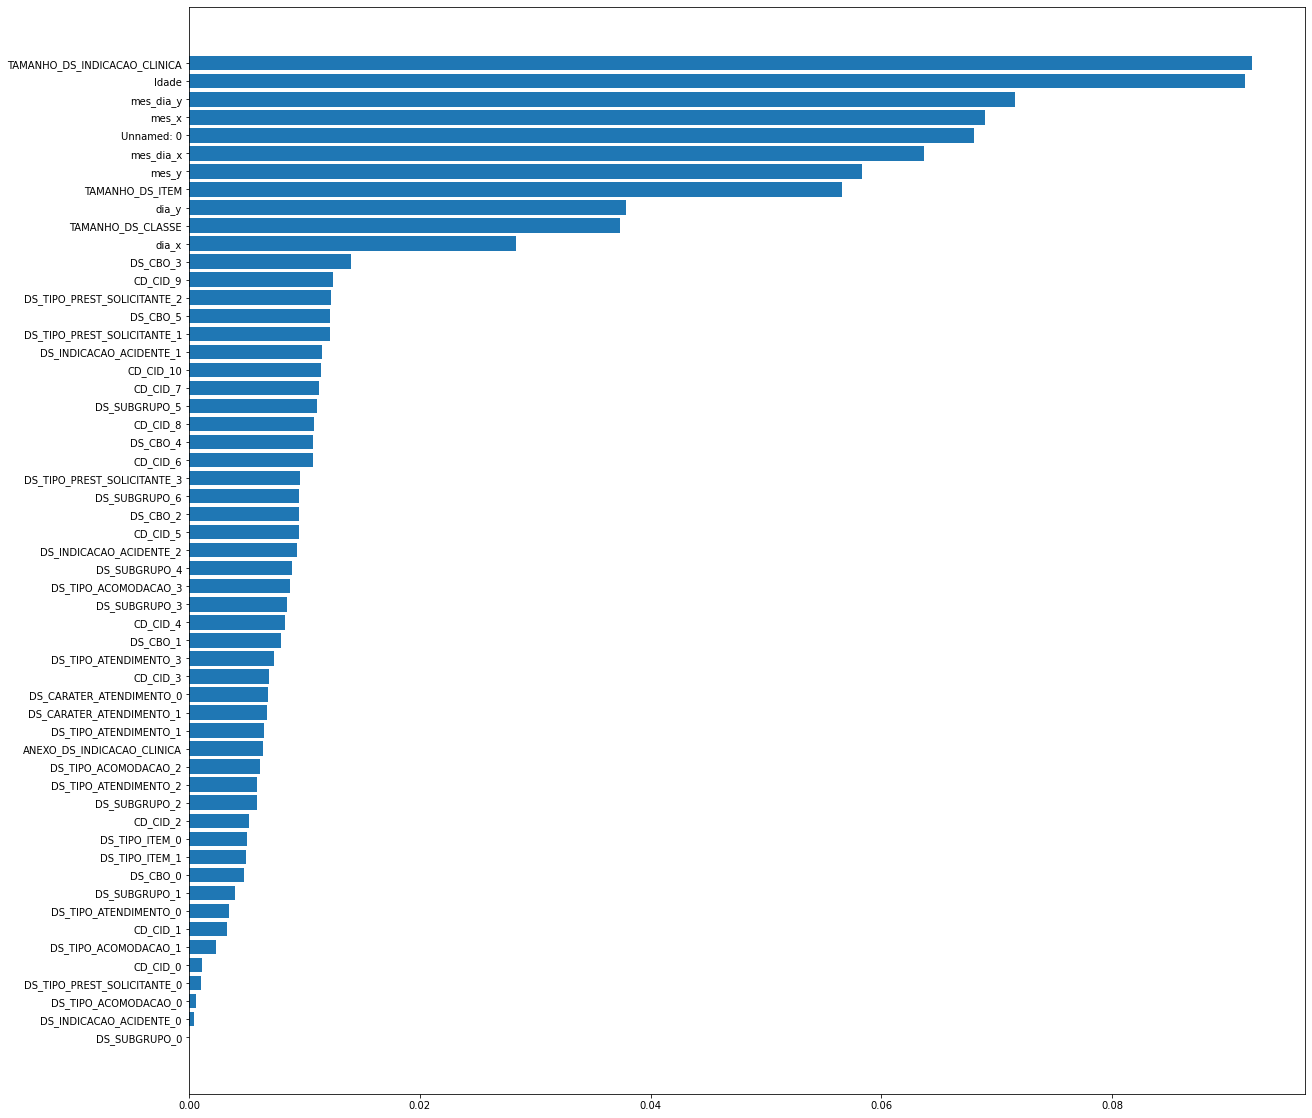

CPU times: user 58.4 s, sys: 486 ms, total: 58.9 s
Wall time: 58.7 s


In [ ]:
%%time
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)
cat_feat = df_train.select_dtypes('object')
pipe = Pipeline([
        ('encoder', ce.BinaryEncoder(cols=cat_feat, return_df=True)), 
        ('model', RandomForestClassifier(class_weight = "balanced", n_estimators=150, max_depth=30, min_samples_split=4))
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_valid)
print(f'f1_score: {f1_score(y_valid, y_pred)}')

plt.figure(figsize=(20, 20))
sort_indexs = pipe['model'].feature_importances_.argsort()
plt.barh(width=pipe['model'].feature_importances_[sort_indexs], y=pipe['model'].feature_names_in_[sort_indexs])
plt.show()

# Permutação de Importância

Aqui é realizada a importância da permutação, que consiste em permutar os valores de uma feature específica e verificar o quanto o desempenho final do modelo é impactado, isso é feito para cada uma das features utilizadas. Desta forma, features que tiveram baixo impacto após a permutação possuem menor relevância para o modelo. Além disso, ao remover esses recursos de pontuação baixa, o desempenho do modelo pode melhorar.

In [ ]:
%%time
result = permutation_importance(pipe, X_valid, y_valid, n_repeats=5, random_state=0, scoring='f1')
for i in result.importances_mean.argsort()[::-1]:
     if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
         print(f"{X_valid.columns[i]:<40}"
               f"{result.importances_mean[i]:.3f}"
               f" +/- {result.importances_std[i]:.3f}")

mes_x                                   0.148 +/- 0.002
DS_TIPO_PREST_SOLICITANTE               0.138 +/- 0.003
CD_CID                                  0.136 +/- 0.002
mes_y                                   0.109 +/- 0.001
TAMANHO_DS_INDICACAO_CLINICA            0.106 +/- 0.001
DS_CBO                                  0.078 +/- 0.002
DS_TIPO_ATENDIMENTO                     0.066 +/- 0.001
DS_CARATER_ATENDIMENTO                  0.055 +/- 0.001
mes_dia_y                               0.049 +/- 0.001
Idade                                   0.048 +/- 0.001
mes_dia_x                               0.047 +/- 0.001
DS_TIPO_ACOMODACAO                      0.040 +/- 0.001
DS_INDICACAO_ACIDENTE                   0.034 +/- 0.001
DS_SUBGRUPO                             0.033 +/- 0.001
dia_y                                   0.020 +/- 0.001
TAMANHO_DS_ITEM                         0.016 +/- 0.000
dia_x                                   0.016 +/- 0.000
TAMANHO_DS_CLASSE                       0.016 +/

# Otimização RF

Nessa seção apenas foi criada uma função para ajudar a escolher alguns hiperparâmetros do modelo. Essas análises foram feitas apenas sobre um único split, em razão do custo.

O hiperparâmetro *class_weight* ficará em "balanced", pois ele é necessário para poder corrigir o problema de desbalanceamento entre as classes autorizado e negado da feature alvo DS_STATUS_ITEM.

In [ ]:
def analise_hyperparameter(X, y, hyperparam, values):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)
    f1_scores = {'train':[],'valid':[]}
    log_losses = {'train':[],'valid':[]}

    for n in values:
        print(f'{f"{hyperparam}: {n}":<30}', end='')
        cat_feat = X.select_dtypes('object')
        pipe = Pipeline([
                        ('encoder', ce.BinaryEncoder(cols=cat_feat, return_df=True)), 
                        ('model', RandomForestClassifier(class_weight = "balanced", **{hyperparam: n}))
        ])
        print('.', end='')
        pipe.fit(X_train, y_train)
        print('.', end='')
        y_pred_train = pipe.predict(X_train)
        y_pred_valid = pipe.predict(X_valid)

        print('.', end='') 
        f1_scores['train'].append(f1_score(y_train, y_pred_train)) 
        log_losses['train'].append(log_loss(y_train, y_pred_train))
        f1_scores['valid'].append(f1_score(y_valid, y_pred_valid))
        log_losses['valid'].append(log_loss(y_valid, y_pred_valid))
        print('.')

        
    fig, ax = plt.subplots(2, 1, figsize=(20, 20))
    ax[0].plot(values, f1_scores['train'], label='train')
    ax[0].plot(values, f1_scores['valid'], label='valid')
    plt.setp(ax[0].get_xticklabels(), fontsize=24)
    plt.setp(ax[0].get_yticklabels(), fontsize=24)
    ax[0].set_title('Train and valid curve', fontweight="bold", fontsize=36)
    ax[0].set_ylabel('f1-score', fontsize=24)
    ax[0].set_xlabel(hyperparam, fontsize=24)
    ax[0].legend(prop={'size': 30})

    ax[1].plot(values, log_losses['train'], label='train')
    ax[1].plot(values, log_losses['valid'], label='valid')
    plt.setp(ax[1].get_xticklabels(), fontsize=24)
    plt.setp(ax[1].get_yticklabels(), fontsize=24)
    ax[1].set_title('Train and valid curve', fontweight="bold", fontsize=36)
    ax[1].set_ylabel('log_loss', fontsize=24)
    ax[1].set_xlabel(hyperparam, fontsize=24)
    ax[1].legend(prop={'size': 30})

    fig.show()


n_estimators: 100             ....
n_estimators: 150             ....
n_estimators: 200             ....
n_estimators: 250             ....
n_estimators: 300             ....
n_estimators: 350             ....
n_estimators: 400             ....
n_estimators: 450             ....
n_estimators: 500             ....
CPU times: user 19min 58s, sys: 32.5 s, total: 20min 31s
Wall time: 20min 26s


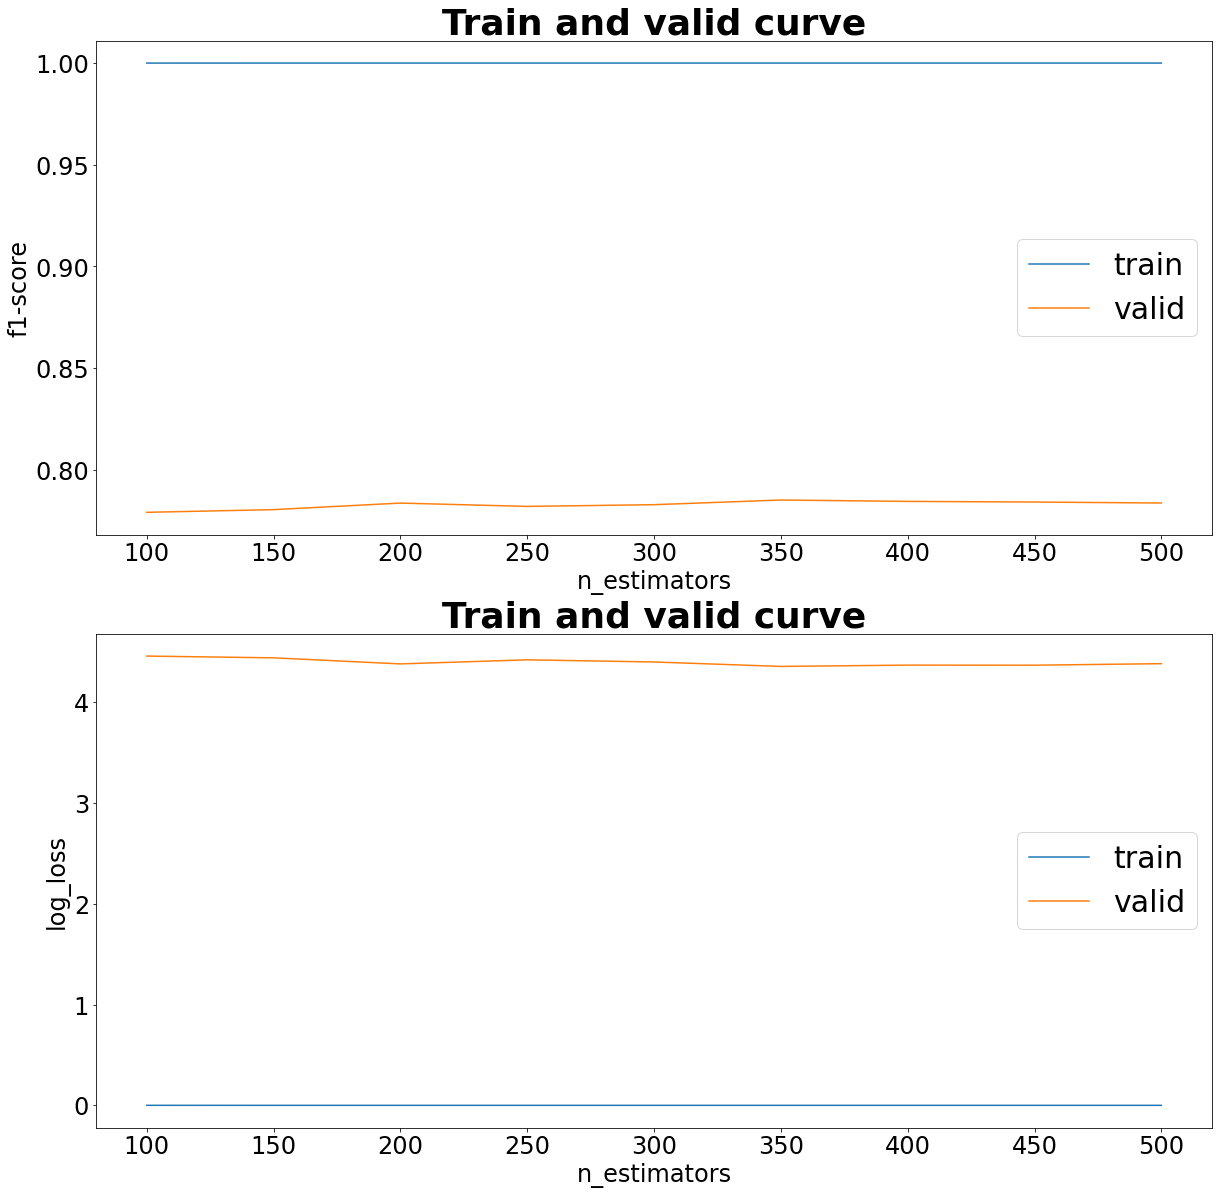

In [ ]:
%%time
analise_hyperparameter(X, y, 'n_estimators', range(100, 501, 50))

min_samples_split: 2          ....
min_samples_split: 4          ....
min_samples_split: 6          ....
min_samples_split: 8          ....
min_samples_split: 10         ....
min_samples_split: 12         ....
min_samples_split: 14         ....
min_samples_split: 16         ....
min_samples_split: 18         ....
min_samples_split: 20         ....
CPU times: user 7min 26s, sys: 35.4 s, total: 8min 2s
Wall time: 8min


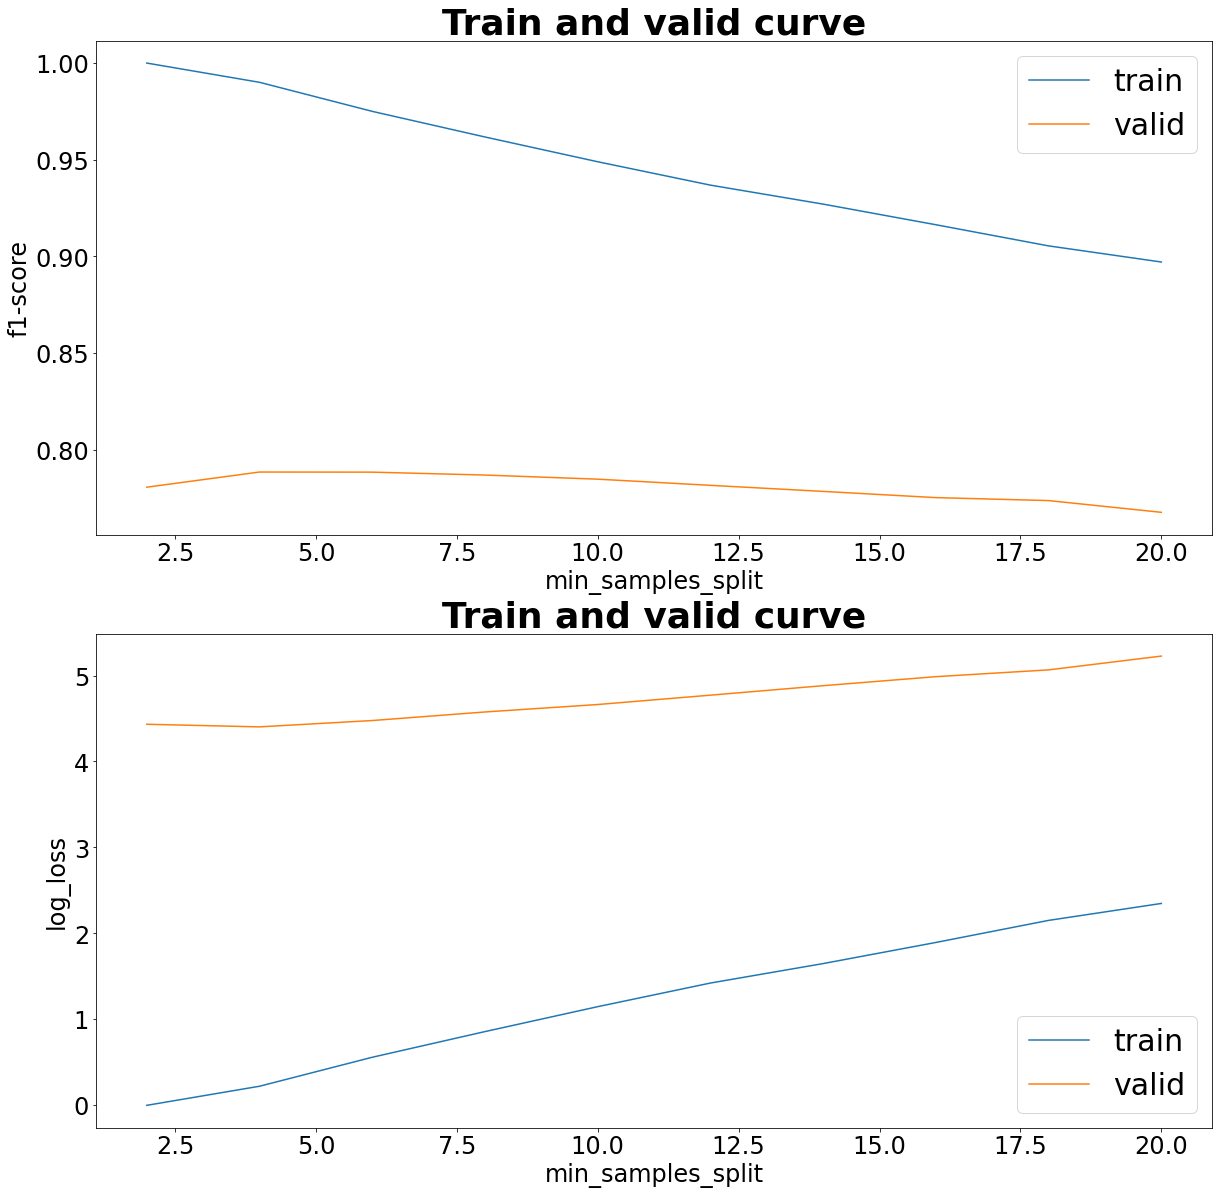

In [ ]:
%%time
analise_hyperparameter(X, y, 'min_samples_split', range(2, 21, 2))


max_depth: 5                  ....
max_depth: 10                 ....
max_depth: 15                 ....
max_depth: 20                 ....
max_depth: 25                 ....
max_depth: 30                 ....
max_depth: 35                 ....
max_depth: 40                 ....
max_depth: 45                 ....
max_depth: 50                 ....
CPU times: user 6min 42s, sys: 15.7 s, total: 6min 58s
Wall time: 6min 57s


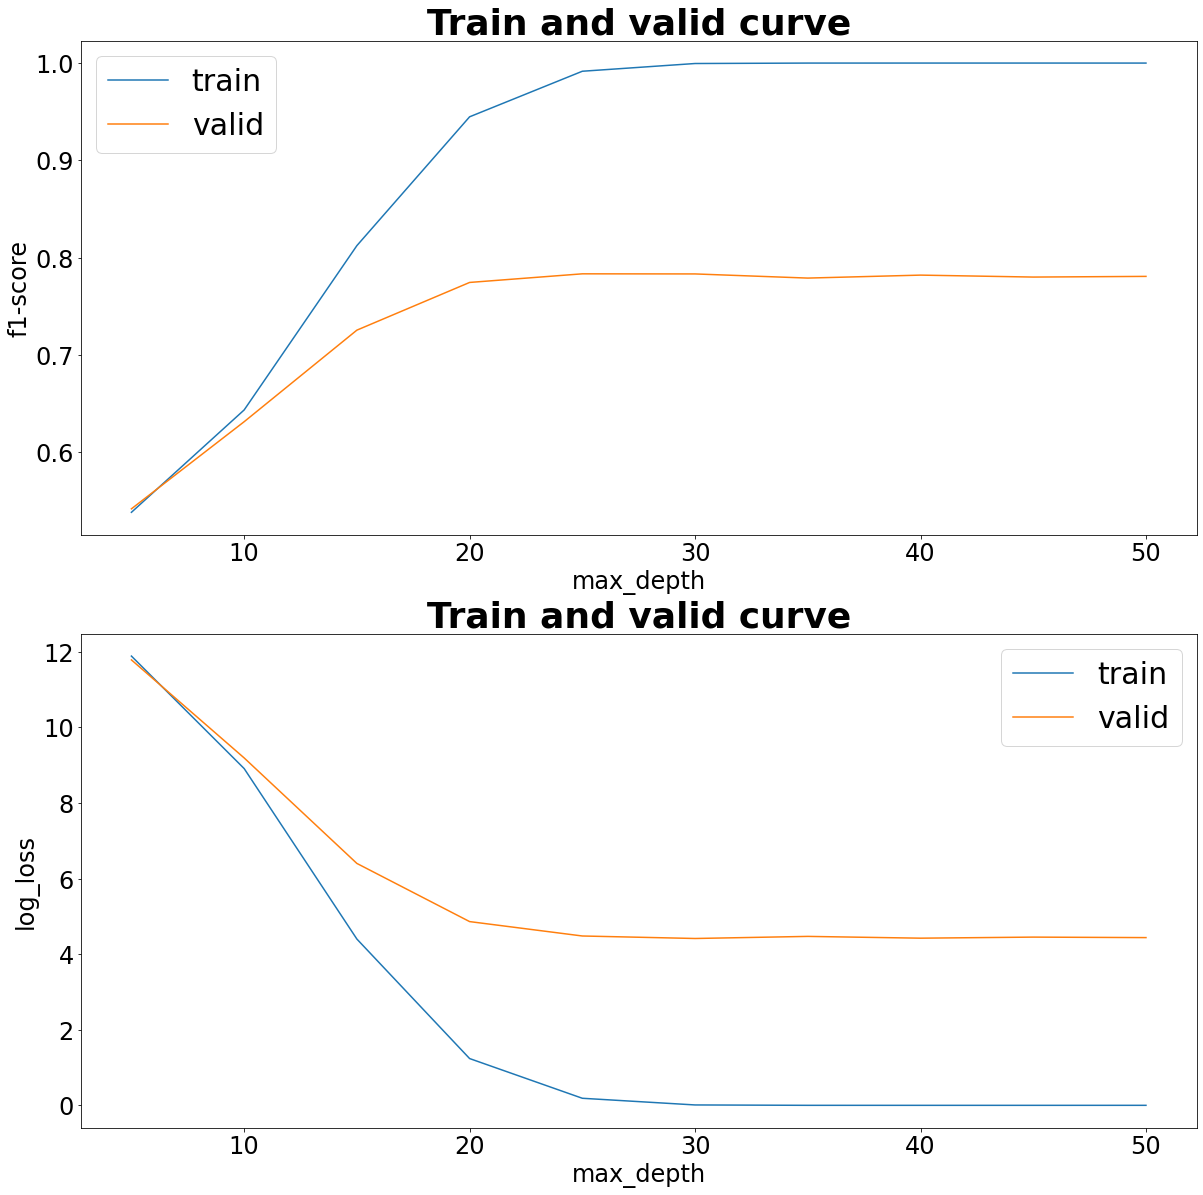

In [ ]:
%%time
analise_hyperparameter(X, y, 'max_depth', range(5, 51, 5))

# Predição

Todos os procedimentos feitos para o dataset de treino também foi feitos para o dataset de teste

In [ ]:
df_test = pd.read_csv('test.csv', delimiter=',')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_test['DT_REQUISICAO'] = pd.to_datetime(df_test['DT_REQUISICAO'].map(jd_to_date).map(lambda t: '-'.join([str(k) for k in t])), format='%Y-%m-%d')
df_test['DT_NASCIMENTO'] = pd.to_datetime(df_test['DT_NASCIMENTO'].map(jd_to_date).map(lambda t: '-'.join([str(k) for k in t])), format='%Y-%m-%d')
df_test['Idade'] = pd.DatetimeIndex(df_test['DT_REQUISICAO']).year - pd.DatetimeIndex(df_test['DT_NASCIMENTO']).year
df_test['dia_x'] = np.cos(2*np.pi*pd.DatetimeIndex(df_test['DT_REQUISICAO']).weekday/7)
df_test['dia_y'] = np.sin(2*np.pi*pd.DatetimeIndex(df_test['DT_REQUISICAO']).weekday/7)
df_test['mes_dia_x'] = np.cos(2*np.pi*pd.DatetimeIndex(df_test['DT_REQUISICAO']).day/31)
df_test['mes_dia_y'] = np.sin(2*np.pi*pd.DatetimeIndex(df_test['DT_REQUISICAO']).day/31)
df_test['mes_x'] = np.cos(2*np.pi*pd.DatetimeIndex(df_test['DT_REQUISICAO']).month/12)
df_test['mes_y'] = np.sin(2*np.pi*pd.DatetimeIndex(df_test['DT_REQUISICAO']).month/12)

df_test['TAMANHO_DS_ITEM'] = df_test['DS_ITEM'].map(lambda s: len(str(s)))
df_test['TAMANHO_DS_CLASSE'] = df_test['DS_CLASSE'].map(lambda s: len(str(s)))
df_test['TAMANHO_DS_INDICACAO_CLINICA'] = df_test['DS_INDICACAO_CLINICA'].fillna('').map(lambda s: len(str(s)))
df_test['ANEXO_DS_INDICACAO_CLINICA'] = df_test['DS_INDICACAO_CLINICA'].fillna('').map(lambda s: 1 if 'anexo' in str(s).lower() else 0)

features_notepad = ['DS_INDICACAO_CLINICA', 'DS_ITEM', 'DS_CLASSE']
features_useless = ['NR_PRODUTO', 'DS_TIPO_SAIDA', 'CD_ITEM']
features_most_values_null = ['QT_TEMPO_DOENCA', 'DS_UNIDADE_TEMPO_DOENCA', 'DS_TIPO_CONSULTA', 'DS_TIPO_DOENCA', 'CD_GUIA_REFERENCIA']
features_seq = ['NR_SEQ_ITEM', 'NR_SEQ_REQUISICAO']
features_date = ['DT_NASCIMENTO', 'DT_REQUISICAO']
features_test = ['QT_DIA_SOLICITADO', 'QT_SOLICITADA', 'DS_TIPO_INTERNACAO', 'DS_TIPO_GUIA', 'DS_GRUPO', 'DS_REGIME_INTERNACAO']

features_excluidas = features_notepad + features_useless + features_most_values_null + features_date + features_test + features_seq
df_test = df_test.drop(features_excluidas, axis=1)

print(f'Loading Dataset...\n\tTrain:\t{df_train.shape}\n\tTest:\t{df_test.shape}')

Loading Dataset...
	Train:	(227122, 22)
	Test:	(186144, 21)


Treinando o modelo com todos os dados de treino.

In [ ]:
%%time
cat_feat = df_train.select_dtypes('object')
pipe = Pipeline([
        ('encoder', ce.BinaryEncoder(cols=cat_feat, return_df=True)), 
        ('model', RandomForestClassifier(class_weight = "balanced", n_estimators=250, max_depth=25, min_samples_split=5, random_state=123))
])
pipe.fit(X, y)
y_pred = pipe.predict(df_test)

CPU times: user 2min 9s, sys: 2.88 s, total: 2min 11s
Wall time: 2min 11s


Verificando a proporção da predição para cada classe

In [ ]:
pd.Series(['Autorizado' if i == 0 else 'Negado' for i in y_pred]).value_counts()

Autorizado    146299
Negado         39845
dtype: int64

# Gerar submissão

In [ ]:
df_test = df_test.set_index('Unnamed: 0')

In [ ]:
submissions = pd.DataFrame({'ID': df_test.index, 'DS_STATUS_ITEM': ['Autorizado' if i == 0 else 'Negado' for i in y_pred]})
submissions.to_csv('SubmissaoRF_37.csv', index=False, header=True)

In [ ]:
submissions

,ID,DS_STATUS_ITEM
0,0,Negado
1,5,Autorizado
2,8,Autorizado
3,13,Autorizado
4,18,Negado
...,...,...
186139,413210,Autorizado
186140,413218,Autorizado
186141,413221,Autorizado
186142,413248,Autorizado
